# Machine Learning Model on Diamond price prediction

## Agenda

1. [Dataset Description](#dataset)
2. [Import relevant packages](#package)
3. [Loading the data](#read)
4. [Data Wrangling/Explore the Dataset](#explore)
5. [Descriptive Statistics of the dataset](#describe)
6. [Exploratory Data Analysis(EDA)](#EDA)
    - 6.1. [Data Visualization](#visualize)
    - 6.2. [Feature Engineering](#feature)
7. [Spliting Dataset into Train and Test](#split)
8. [Learning Algorithm Selection](#algo)
    - 8.1 [Linear Regression Model](#linreg)
    - 8.2 [Decision Tree Regression Model](#dt)
    - 8.3 [Random Forest Regression Model](#rf)
    - 8.4 [KNeighbors Regression Model](#knn)
9. [Model Performance Assessment](#perform)
10. [Closing Remarks](#close)

## 1. Dataset Description <a id='dataset'>

<p/>
This dataset contains prices and other attributes of almost 54,000 diamonds.
The description of data are as follows:

<p/>
<b>Data Fields:</b>
<br/>
Price- price in US dollars (\$326--\$18,823) <br/>
Carat- weight of the diamond (0.2--5.01) <br/>
Cut- quality of the cut (Fair, Good, Very Good, Premium, Ideal) <br/>
Color- diamond colour, from J (worst) to D (best) <br/>
Clarity- a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2,
VVS1, IF (best)) <br/>
x- length in mm (0--10.74) <br/>
y- width in mm (0--58.9) <br/>
z- depth in mm (0--31.8) <br/>
depth- total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79) <br/>
table- width of top of diamond relative to widest point (43--95) <br/>

<p/>
Objective: Predict the price of the diamond using other attributes.

## 2. Import relevent packages <a id='package'>

In [181]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

## 3. Loading the data <a id='read'>

We'll be working with a dataset Titanic that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/titanic/data)).

#### Through Dask

In [182]:
#Read data through Dask and compute time taken to read
t_start = time.time()
diamonds = dd.read_csv('diamonds.csv')
t_end = time.time()
print('dd.read_csv(): {} s'.format(t_end-t_start)) # time [s]

dd.read_csv(): 0.07200002670288086 s


#### Through Pandas

In [183]:
#Read data through Pandas and compute time taken to read
t_start = time.time()
diamonds = pd.read_csv('diamonds.csv')
t_end = time.time()
print('pd.read_csv(): {} s'.format(t_end-t_start)) # time [s]

pd.read_csv(): 0.3400001525878906 s


## 4. Data Wrangling/Explore the Dataset <a id='explore'>

In [184]:
#Getting the head of the dataset
diamonds.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [185]:
#Shape of the dataset
diamonds.shape

(53940, 11)

**We have 53940 observations, 11 features, and our target variable, Price**

In [186]:
#Data Type of features for dataset
diamonds.dtypes

Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
price           int64
x             float64
y             float64
z             float64
dtype: object

In [187]:
#Info of the dataset
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
Unnamed: 0    53940 non-null int64
carat         53940 non-null float64
cut           53940 non-null object
color         53940 non-null object
clarity       53940 non-null object
depth         53940 non-null float64
table         53940 non-null float64
price         53940 non-null int64
x             53940 non-null float64
y             53940 non-null float64
z             53940 non-null float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [188]:
#Checking for null values in dataset
diamonds.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [189]:
#Checking for duplicate records in dataset
duplicate_records = diamonds[diamonds.duplicated()]
print("Duplicate Rows except first occurrence based on all columns are :")
print(len(duplicate_records))

Duplicate Rows except first occurrence based on all columns are :
0


## 5. Descriptive Statistics of the dataset <a id='describe'> 

In [190]:
#Summary statistics for the dataset
diamonds.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


**Do you see the Min. Values of X, Y and Z. It can't be possible..!!**
**It doesn't make any sense to have either of Length or Width or Height to be zero..**
**We will take care of it during EDA**

## 6. Exploratory Data Analysis(EDA) <a id='EDA'> 

In [191]:
#Remove unwanted column
diamonds = diamonds.drop(['Unnamed: 0'], axis =1)
diamonds.head(2)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31


In [192]:
#Getting x,y & z having 0 value
diamonds.loc[(diamonds['x']==0) | (diamonds['y']==0) | (diamonds['z']==0)]

,carat,cut,color,clarity,depth,table,price,x,y,z
2207,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0
2314,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0
4791,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0
5471,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0
10167,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0
11182,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.0
11963,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.0
13601,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0
15951,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
24394,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.0


In [193]:
len(diamonds.loc[(diamonds['x']==0) | (diamonds['y']==0) | (diamonds['z']==0)])

20

**We can see there are 20 rows with Dimensions 'Zero'. We'll Drop them as it seems better choice instead of filling them with any of Mean or Median.**

In [194]:
#Dropping Rows with Dimensions 'Zero'
diamonds = diamonds[(diamonds[['x','y','z']] != 0).all(axis=1)]
diamonds.shape

(53920, 10)

### 6.1. Data Visualization  <a id='visualize'>

C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


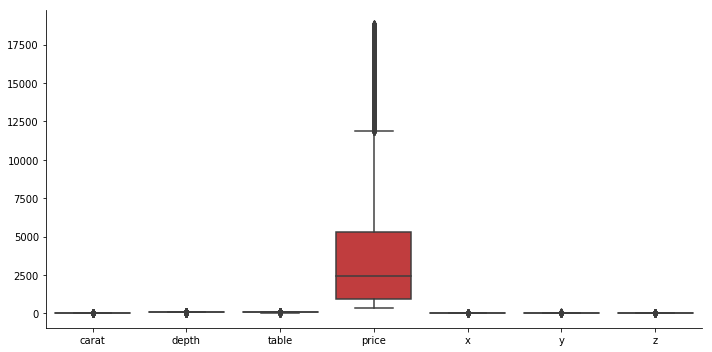

In [195]:
sns.factorplot(data=diamonds , kind='box' , size=5, aspect=2)

**The Values are Distributed over a Small Scale.**

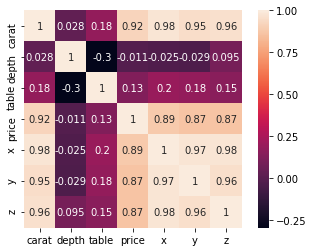

In [196]:
#Correlation Map
corr = diamonds.corr()
sns.heatmap(data=corr, square=True , annot=True, cbar=True)

#### Observations:
- The Price of the Diamond is highly correlated to Carat, and its Dimensions.
- The Length(x) , Width(y) and Height(z) is higly correlated to Price and with each other.
- Depth is inversely related to Price.

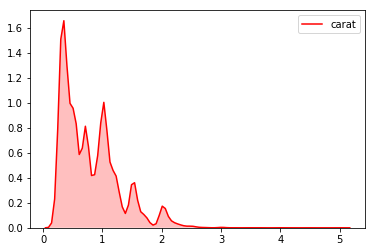

In [197]:
#Carat
sns.kdeplot(diamonds['carat'], shade=True , color='r')

C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


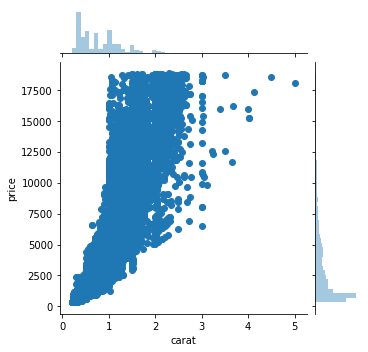

In [198]:
#Carat vs Price
sns.jointplot(x='carat' , y='price' , data=diamonds , size=5)

**It seems that Carat varies with Price Exponentially.**

C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


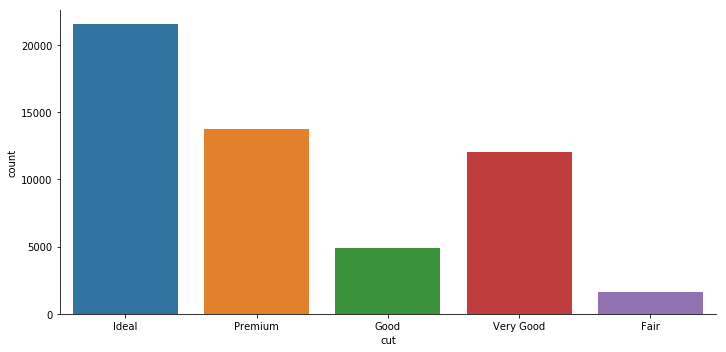

In [199]:
#Cut
sns.factorplot(x='cut', data=diamonds , kind='count',aspect=2 )

C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


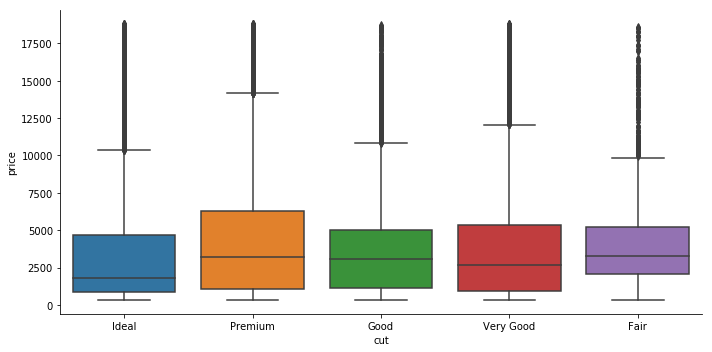

In [200]:
#Cut vs Price
sns.factorplot(x='cut', y='price', data=diamonds, kind='box' ,aspect=2)

**As we can see Premium Cut on Diamonds are the most Expensive, followed by Very Good Cut.**

C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


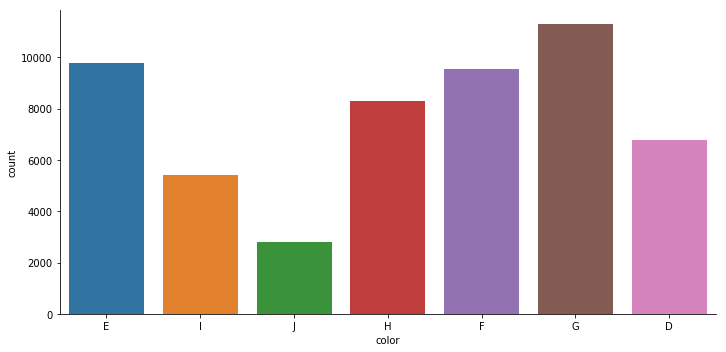

In [201]:
#Color
sns.factorplot(x='color', data=diamonds , kind='count',aspect=2 )

C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


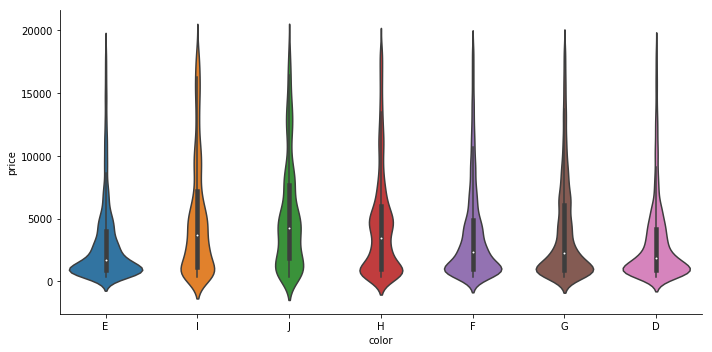

In [202]:
#Color Vs Price
sns.factorplot(x='color', y='price' , data=diamonds , kind='violin', aspect=2)

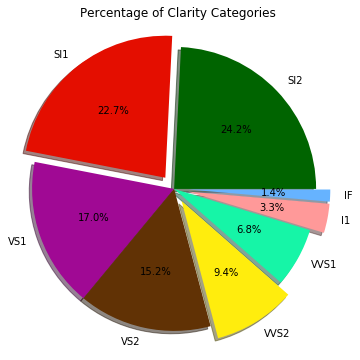

In [203]:
#Clarity
labels = diamonds.clarity.unique().tolist()
sizes = diamonds.clarity.value_counts().tolist()
colors = ['#006400', '#E40E00', '#A00994', '#613205', '#FFED0D', '#16F5A7','#ff9999','#66b3ff']
explode = (0.0, 0.1, 0, 0, 0.1, 0, 0.1,0.1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=0)
plt.axis('equal')
plt.title("Percentage of Clarity Categories")
plt.plot()
fig=plt.gcf()
fig.set_size_inches(6,6)
plt.show()

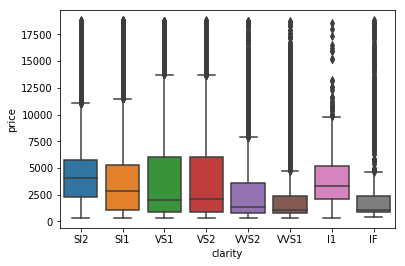

In [204]:
#Clarity Vs Price
sns.boxplot(x='clarity', y='price', data=diamonds )

**It seems that VS1 and VS2 affect the Diamond's Price equally having quite high Price margin.**

(array([3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 4.0000e+00, 1.1000e+01, 4.3000e+01, 2.1900e+02,
        1.4240e+03, 5.0730e+03, 1.8242e+04, 2.2649e+04, 5.0330e+03,
        8.5100e+02, 2.3400e+02, 8.7000e+01, 2.7000e+01, 1.1000e+01,
        3.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([43.  , 44.44, 45.88, 47.32, 48.76, 50.2 , 51.64, 53.08, 54.52,
        55.96, 57.4 , 58.84, 60.28, 61.72, 63.16, 64.6 , 66.04, 67.48,
        68.92, 70.36, 71.8 , 73.24, 74.68, 76.12, 77.56, 79.  ]),
 <a list of 25 Patch objects>)

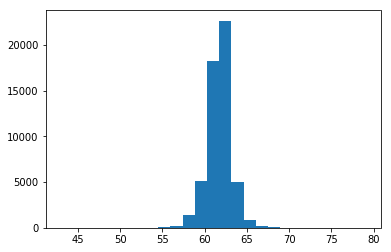

In [205]:
#Depth
plt.hist('depth' , data=diamonds , bins=25)

C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


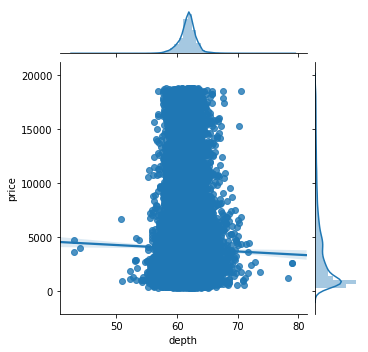

In [206]:
#Depth Vs Price
sns.jointplot(x='depth', y='price' , data=diamonds , kind='regplot', size=5)

**We can Infer from the plot that the Price can vary heavily for the same Depth.**

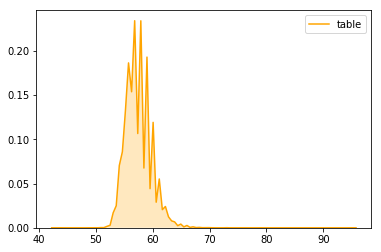

In [207]:
#Table
sns.kdeplot(diamonds['table'] ,shade=True , color='orange')

C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


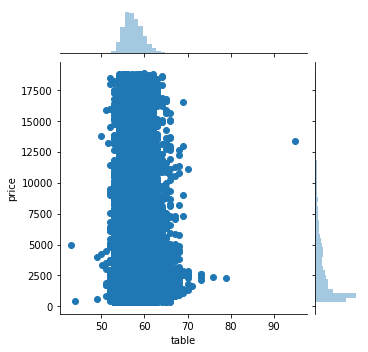

In [208]:
#Table Vs Price
sns.jointplot(x='table', y='price', data=diamonds , size=5)

(2, 10)

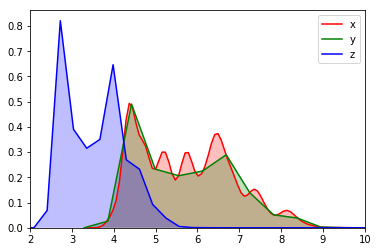

In [209]:
#Dimensions
sns.kdeplot(diamonds['x'] ,shade=True , color='r' )
sns.kdeplot(diamonds['y'] , shade=True , color='g' )
sns.kdeplot(diamonds['z'] , shade= True , color='b')
plt.xlim(2,10)

**As the dimensions increases, obviously the price rises as more and more natural resources are utilised.**

### 6.2. Feature Engineering  <a id='feature'>

In [210]:
#Creating new feature 'Volume'
diamonds['volume'] = diamonds['x']*diamonds['y']*diamonds['z']
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250


(0, 50000)

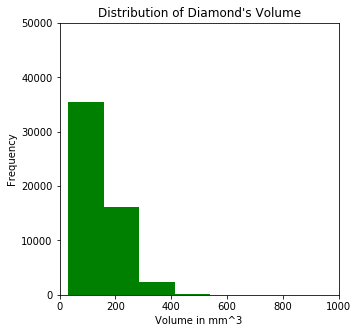

In [211]:
plt.figure(figsize=(5,5))
plt.hist( x=diamonds['volume'] , bins=30 ,color='g')
plt.xlabel('Volume in mm^3')
plt.ylabel('Frequency')
plt.title('Distribution of Diamond\'s Volume')
plt.xlim(0,1000)
plt.ylim(0,50000)

C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


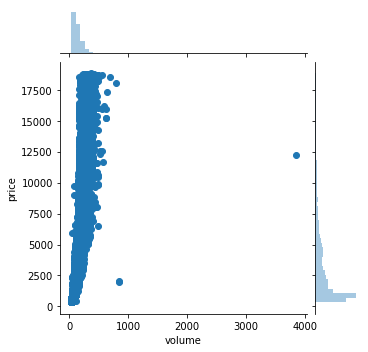

In [212]:
#Volume Vs Price
sns.jointplot(x='volume', y='price' , data=diamonds, size=5)

**It seems that there is linear relationship between Price and Volume.**

In [213]:
#Dropping x,y and z
diamonds.drop(['x','y','z'], axis=1, inplace= True)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,51.917250


##### Categorical Encoding - Label Encoding.

In [214]:
label_cut = LabelEncoder()
label_color = LabelEncoder()
label_clarity = LabelEncoder()


diamonds['cut'] = label_cut.fit_transform(diamonds['cut'])
diamonds['color'] = label_color.fit_transform(diamonds['color'])
diamonds['clarity'] = label_clarity.fit_transform(diamonds['clarity'])

In [215]:
diamonds.head(2)

,carat,cut,color,clarity,depth,table,price,volume
0,0.23,2,1,3,61.5,55.0,326,38.202030
1,0.21,3,1,2,59.8,61.0,326,34.505856


## 7. Spliting Dataset into Train and Test <a id='split'> 

In [216]:
#Assigning X and y variables
X = diamonds.drop('price',1)
y = diamonds['price']

In [217]:
#Splitting the dataset into train and test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123)

## 8. Learning Algorithm Selection<a id='algo'> 

In [218]:
#Collect all R2 Scores.
R2_Scores = []
models = ['Linear Regression' ,'DecisionTree Regression','RandomForest Regression','KNeighbours Regression']

### 8.1. Linear Regression Model <a id='linreg'>

In [219]:
lr = LinearRegression()
lr.fit(X_train , y_train)
accuracies = cross_val_score(estimator = lr, X = X_train, y = y_train, cv = 5,verbose = 1)
y_pred = lr.predict(X_test)
print('')
print('####### Linear Regression #######')
print('Score : %.4f' % lr.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)

R2_Scores.append(r2)


####### Linear Regression #######
Score : 0.8786
[0.88076208 0.87923481 0.8839412  0.87278391 0.88127678]

MSE    : 1943629.85 
MAE    : 935.69 
RMSE   : 1394.14 
R2     : 0.88 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


### 8.2. Decision Tree Regression Model <a id='dt'>

In [220]:
dt= DecisionTreeRegressor()
dt.fit(X_train,y_train)
accuracies = cross_val_score(estimator = dt, X = X_train, y = y_train, cv = 5,verbose = 1)
y_pred = dt.predict(X_test)
print('')
print('####### Decision Tree #######')
print('Score : %.4f' % dt.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)

R2_Scores.append(r2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



####### Decision Tree #######
Score : 0.9665
[0.96157981 0.9634498  0.96539757 0.96723964 0.96212344]

MSE    : 535500.66 
MAE    : 359.28 
RMSE   : 731.78 
R2     : 0.97 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


### 8.3. Random Forest Regression Model <a id='rf'>

In [221]:
rf=RandomForestRegressor()
rf.fit(X_train,y_train)
accuracies = cross_val_score(estimator = rf, X = X_train, y = y_train, cv = 5,verbose = 1)
y_pred = rf.predict(X_test)
print('')
print('####### Random Forest #######')
print('Score : %.4f' % rf.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)

R2_Scores.append(r2)

C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.3s finished



####### Random Forest #######
Score : 0.9790
[0.97822843 0.97510222 0.9792411  0.97864893 0.9776193 ]

MSE    : 335821.94 
MAE    : 295.21 
RMSE   : 579.50 
R2     : 0.98 


### 8.4. KNeighbors Regression Model <a id='knn'>

In [222]:
knn = KNeighborsRegressor()
knn.fit(X_train , y_train)
accuracies = cross_val_score(estimator = knn, X = X_train, y = y_train, cv = 5,verbose = 1)
y_pred = knn.predict(X_test)
print('')
print('###### KNeighbours Regression ######')
print('Score : %.4f' % knn.score(X_test, y_test))
print(accuracies)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print('')
print('MSE    : %0.2f ' % mse)
print('MAE    : %0.2f ' % mae)
print('RMSE   : %0.2f ' % rmse)
print('R2     : %0.2f ' % r2)

R2_Scores.append(r2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.5s finished



###### KNeighbours Regression ######
Score : 0.9369
[0.9368434  0.93664475 0.93594319 0.93197877 0.93658254]

MSE    : 1009388.75 
MAE    : 499.23 
RMSE   : 1004.68 
R2     : 0.94 


## 9. Model Performance Assessment <a id='perform'> 

In [223]:
#Visualizing R2-Score of Algorithms
compare = pd.DataFrame({'Algorithms' : models , 'R2-Scores' : R2_Scores})
compare.sort_values(by='R2-Scores' ,ascending=False)

,Algorithms,R2-Scores
2,RandomForest Regression,0.979017
1,DecisionTree Regression,0.966541
3,KNeighbours Regression,0.936931
0,Linear Regression,0.878557


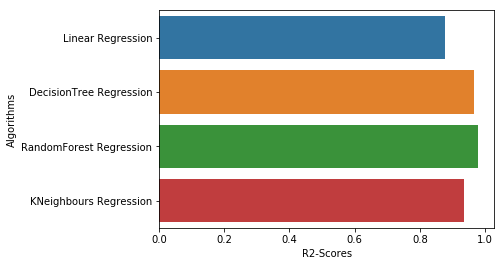

In [224]:
sns.barplot(x='R2-Scores' , y='Algorithms' , data=compare)

C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\pc\Anaconda3\Anaconda\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


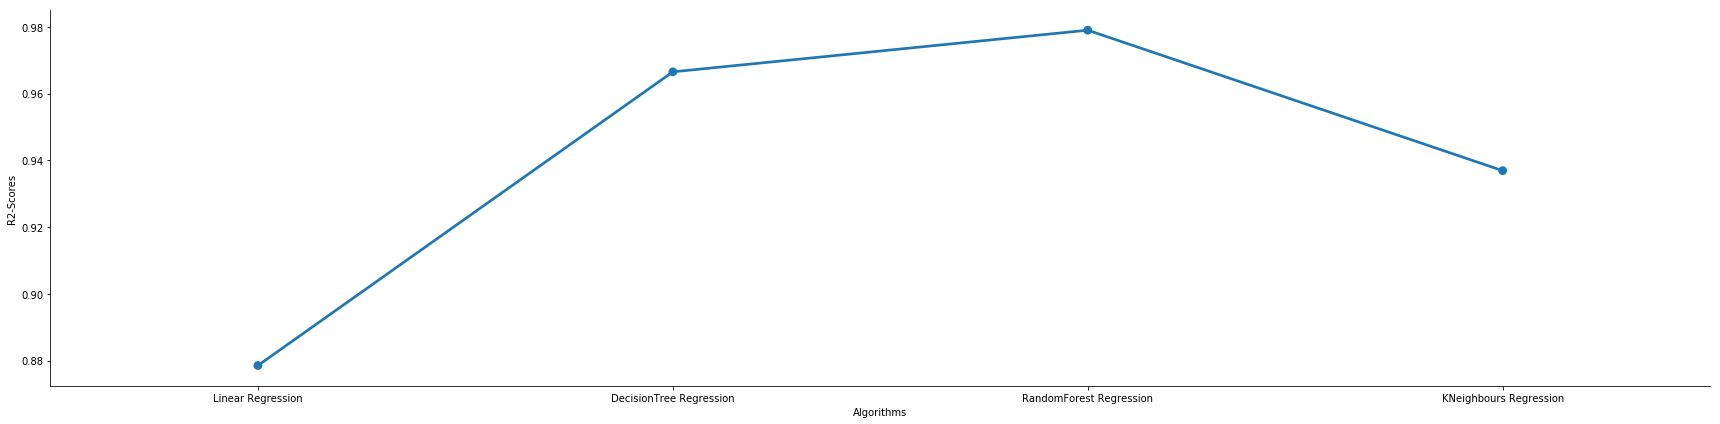

In [225]:
sns.factorplot(x='Algorithms', y='R2-Scores' , data=compare, size=6 , aspect=4)

## 10. Closing Remarks <a id='close'> 

**It can be observed that RandomForest Regression Model is performing well for the problem statement, giving highest R2-Score of ~98%**